## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(20798, 19)

In [12]:
privileged_groups

[{'gender': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[4. 5. 7. ... 6. 6. 7.]
 [6. 3. 7. ... 3. 6. 6.]
 [7. 9. 7. ... 4. 6. 6.]
 ...
 [3. 6. 7. ... 3. 5. 5.]
 [1. 2. 7. ... 2. 5. 5.]
 [3. 5. 7. ... 4. 6. 7.]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                                  \
                                                                           
                                 decile3 decile1 race cluster  lsat ugpa   
instance names                                                             
19799                       1.0      4.0     5.0  7.0     5.0  39.0  3.6   
8319                        1.0      6.0     3.0  7.0     3.0  35.0  3.5   
195                         1.0      7.0     9.0  7.0     1.0  38.0  3.0   
2168                        1.0      9.0     9.0  7.0     4.0  38.0  3.3   
4722                        1.0     10.0    10.0  7.0     3.0  42.0  3.1   
...                         ...      ...     ...  ...     ...   ...  ...   
15008                       1.0      4.0     2.0  7.0     4.0  33.5  2.7   
19183                       1.0      1.0     1.0  3.0     4.0  29.0  2.9   
19578                       1.0      3.0     6.0  7.0     3.0  31.5  3.2   
949         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[5. 5. 7. ... 3. 5. 5.]
 [1. 1. 3. ... 3. 5. 5.]
 [5. 2. 7. ... 6. 6. 6.]
 ...
 [2. 2. 7. ... 2. 6. 6.]
 [6. 5. 8. ... 3. 6. 7.]
 [3. 7. 7. ... 4. 6. 8.]]
no bias type specified
#### Training Dataset shape
(10399, 19)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'race2', 'other', 'asian', 'black', 'hisp', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5780.0 4619.0
base_pos unpriv:  0.9417622862091362
base_pos priv:  0.9534602076124568
number of favorable labels:  9861
Difference in mean outcomes between unprivileged and privileged groups = -0.011698
#### Train shape, validation shape, 

Number of training samples (ntrain): 5511
Number of test samples (ntest): 5639
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0.08223809823697212
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 538, Test = 502
  AUC: 0.73
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.34
  Positive predictive value: 0.78
  Optimal thershold: -1.6171007851796695
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9861, Test = 9897
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -0.0953101798043249
)
MIA_Result(
  N

Number of training samples (ntrain): 4350
Number of test samples (ntest): 4258
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 256
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5511
Number of test samples (ntest): 5639
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.24
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 538, Test = 502
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.29
  Positive predictive value: 0.73
  Optimal thershold: -2.0794415416798357
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9861, Test = 989

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4350
Number of test samples (ntest): 4258
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 256
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5511
Number of test samples (ntest): 5639
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -0.008060948261632239
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 538, Test = 502
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.30
  Positive predictive value: 0.74
  Optimal thershold: -2.0476928433652555
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 246
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4350
Number of test samples (ntest): 4258
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 256
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5511
Number of test samples (ntest): 5639
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -0.03175635512639431
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 538, Test = 502
  AUC: 0.75
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.36
  Positive predictive va

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_ex

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\exponentiated_gradient.py:346: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred[t] = np.zeros(len(X))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\exponentiated_gradient.py:346: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

Accuracy for threshold: 0.01  is: 0.9515338013270507
Balanced accuracy is:  0.5008444548571401
Accuracy for threshold: 0.02  is: 0.9515338013270507
Balanced accuracy is:  0.5008444548571401
Accuracy for threshold: 0.03  is: 0.9516299644196557
Balanced accuracy is:  0.5027859663699451
Accuracy for threshold: 0.04  is: 0.9516299644196557
Balanced accuracy is:  0.5027859663699451
Accuracy for threshold: 0.05  is: 0.9514376382344456
Balanced accuracy is:  0.5036304212270852
Accuracy for threshold: 0.060000000000000005  is: 0.9514376382344456
Balanced accuracy is:  0.5045759168036352
Accuracy for threshold: 0.06999999999999999  is: 0.9515338013270507
Balanced accuracy is:  0.5055719327398902
Accuracy for threshold: 0.08  is: 0.9516299644196557
Balanced accuracy is:  0.5065679486761452
Accuracy for threshold: 0.09  is: 0.9516299644196557
Balanced accuracy is:  0.5065679486761452
Accuracy for threshold: 0.09999999999999999  is: 0.9514376382344456
Balanced accuracy is:  0.5074124035332853
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 246
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4350
Number of test samples (ntest): 4258
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 269
Number of test samples (ntest): 256
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5511
Number of test samples (ntest): 5639
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.0008169327999507434
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 538, Test = 502
  AUC: 0.75
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.39
  Positive predictive 

Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -2.53677848049484
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.42
  Positive predictive value: 0.74
  Optimal thershold: -2.3025

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.484906649788
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.72
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.33
  Positive predictive value: 0.73
  Optimal thershold: -2.484906649788
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.41
  Positive predictive value: 0.74
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.712329858096854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.34
  Positive predictive value: 0.76
  Optimal thershold: -2.084845271566609
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_ex

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Accuracy for threshold: 0.01  is: 0.9508606596788153
Balanced accuracy is:  0.4999494387703509
Accuracy for threshold: 0.02  is: 0.9507644965862102
Balanced accuracy is:  0.4998988775407018
Accuracy for threshold: 0.03  is: 0.9507644965862102
Balanced accuracy is:  0.4998988775407018
Accuracy for threshold: 0.04  is: 0.9508606596788153
Balanced accuracy is:  0.5008792696975646
Accuracy for threshold: 0.05  is: 0.9509568227714204
Balanced accuracy is:  0.5018596618544273
Accuracy for threshold: 0.060000000000000005  is: 0.9508606596788153
Balanced accuracy is:  0.5027389315519918
Accuracy for threshold: 0.06999999999999999  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.08  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.09  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.09999999999999999  is: 0.9507644965862102
Balanced accuracy is:  0.5036182012495564
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\exponentiated_gradient.py:346: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred[t] = np.zeros(len(X))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\exponentiated_gradient.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.40
  Positive predictive 

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -2.53677848049484
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.42
  Positive predictive value

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.484906649788
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.72
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.33
  Positive predictive value: 0.73
  Optimal thershold: -2.484906649788
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.41
  Positive predictive value: 0.74
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.712329858096854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.34
  Positive predictive value: 0.76
  Optimal thershold: -2.084845271566609
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_exponentiated_gradient\_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_ex

Accuracy for threshold: 0.01  is: 0.9508606596788153
Balanced accuracy is:  0.4999494387703509
Accuracy for threshold: 0.02  is: 0.9507644965862102
Balanced accuracy is:  0.4998988775407018
Accuracy for threshold: 0.03  is: 0.9507644965862102
Balanced accuracy is:  0.4998988775407018
Accuracy for threshold: 0.04  is: 0.9508606596788153
Balanced accuracy is:  0.5008792696975646
Accuracy for threshold: 0.05  is: 0.9509568227714204
Balanced accuracy is:  0.5018596618544273
Accuracy for threshold: 0.060000000000000005  is: 0.9508606596788153
Balanced accuracy is:  0.5027389315519918
Accuracy for threshold: 0.06999999999999999  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.08  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.09  is: 0.9507644965862102
Balanced accuracy is:  0.5026883703223427
Accuracy for threshold: 0.09999999999999999  is: 0.9507644965862102
Balanced accuracy is:  0.5036182012495564
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.40
  Positive predictive 

## Display Output

In [18]:
priv_metric_orig_copy = priv_metric_orig

In [19]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 17560.0, 'total_unpriv': 13637.0})

In [20]:
priv_metric_orig

defaultdict(float, {'total_priv': 17560.0, 'total_unpriv': 13637.0})

In [21]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
10399
2)

               total_priv  total_unpriv
num_instance                           
orig          5853.333333   4545.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.948777       0.051223    0.954719      0.045281      0.941111   
transf      0.954717       0.045283    0.954719      0.045281      0.954716   

         unpriv_unfavor  
dataset                  
orig           0.058889  
transf         0.045284  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.580291      -0.029224  0.013473      -0.013133   
dt_syn                     0.584535      -0.035543  0.013493      -0.013187   
dt_dir                     0.583804      -0.045010  0.014922      -0.014505   
dt_rew                     0.57190

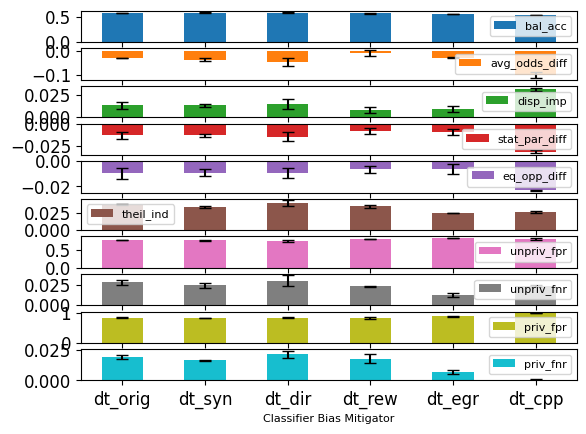

In [22]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

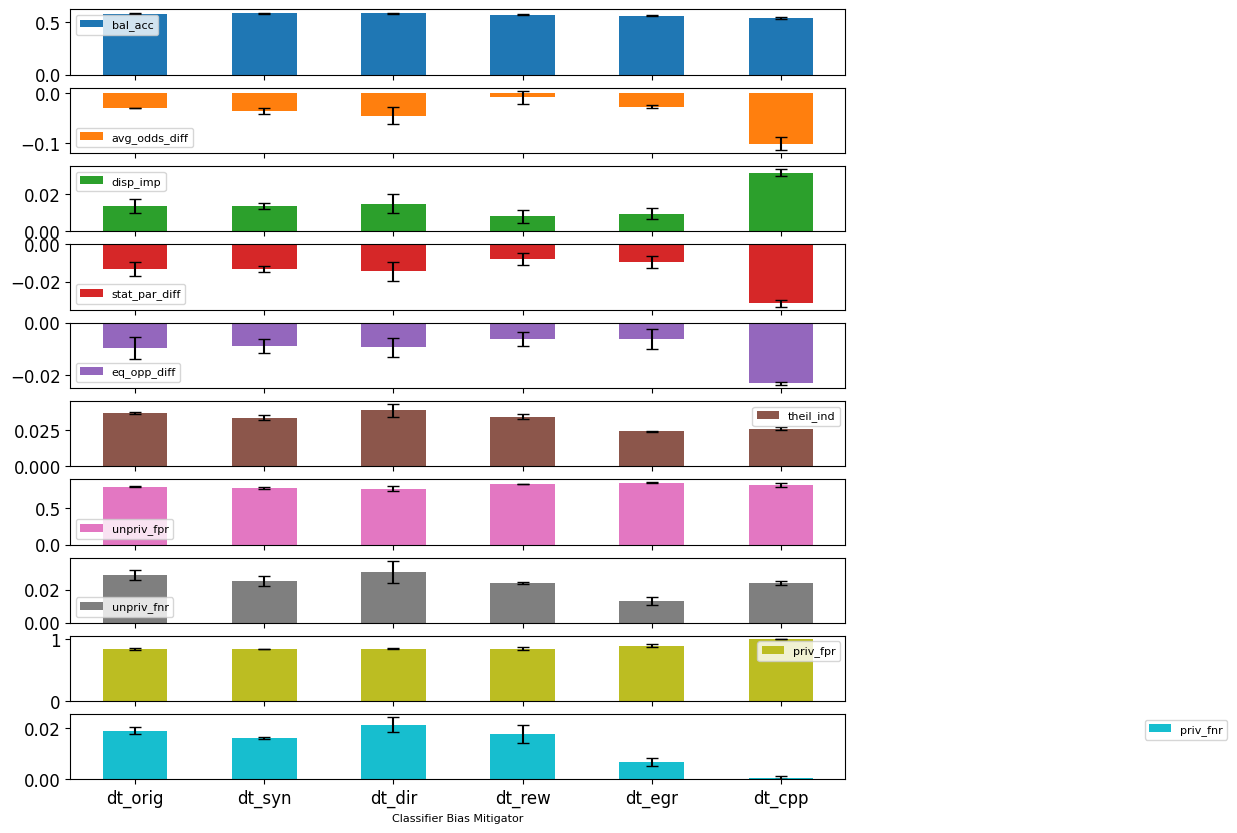

In [23]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [24]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.580291,-0.029224,0.013473,-0.013133,-0.009715,0.036758,0.791131,0.028763,0.839864,0.019048
dt_syn,0.584535,-0.035543,0.013493,-0.013187,-0.008975,0.033592,0.778936,0.025220,0.841046,0.016245
dt_dir,0.583804,-0.045010,0.014922,-0.014505,-0.009429,0.038712,0.765605,0.030729,0.846195,0.021300
dt_rew,0.571907,-0.008438,0.008013,-0.007830,-0.006253,0.034319,0.830186,0.024026,0.840808,0.017772
dt_egr,0.559569,-0.027441,0.009546,-0.009440,-0.006244,0.024164,0.846381,0.013064,0.895018,0.006821
dt_cpp,0.539538,-0.101220,0.031603,-0.031577,-0.023129,0.026011,0.818144,0.023854,0.997455,0.000724


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [25]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [26]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517854,0.696958,0.511188,0.687012,0.513594,0.717752,0.509807
syn,0.515675,0.659700,0.510144,0.660576,0.514851,0.661403,0.507951
dir,0.521733,0.686601,0.515914,0.676194,0.517974,0.705173,0.516396
rew,0.515659,0.674361,0.510234,0.665826,0.513632,0.688360,0.508945
egr,0.533304,0.698244,0.535946,0.698690,0.540167,0.709640,0.532729


In [27]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [28]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [29]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.687012,0.513594,0.717752,0.509807
syn,0.660576,0.514851,0.661403,0.507951
dir,0.676194,0.517974,0.705173,0.516396
rew,0.665826,0.513632,0.688360,0.508945
egr,0.698690,0.540167,0.709640,0.532729


<Axes: xlabel='Classifier MIA Attacks'>

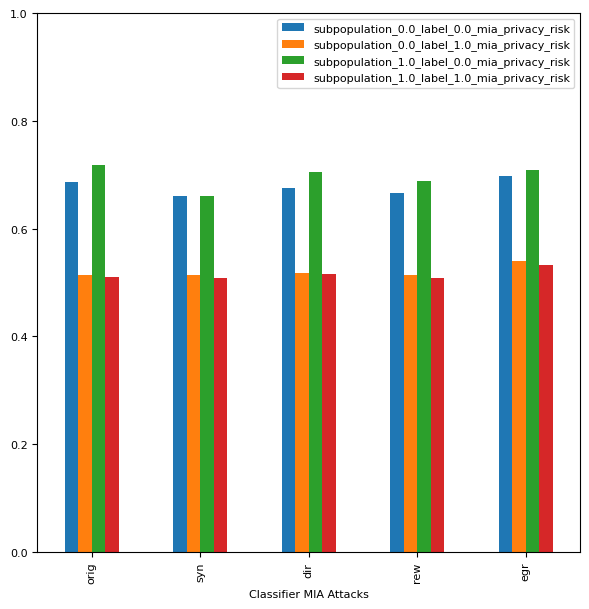

In [30]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [31]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.687012  0.660576  0.676194  0.665826  0.69869
subpopulation_0.0_label_1.0_mia_privacy_risk  0.513594  0.514851  0.517974  0.513632  0.540167
subpopulation_1.0_label_0.0_mia_privacy_risk  0.717752  0.661403  0.705173  0.68836   0.70964
subpopulation_1.0_label_1.0_mia_privacy_risk  0.509807  0.507951  0.516396  0.508945  0.532729


### Visualizing using novel technique

In [32]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [33]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [34]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517309
1,orig,entire_dataset_mia_privacy_risk,0.518127
2,orig,entire_dataset_mia_privacy_risk,0.518127
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.670896
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.709989
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.714147
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.714147
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.527290
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.535448


In [35]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517309
1,orig,entire_dataset_mia_privacy_risk,0.518127
2,orig,entire_dataset_mia_privacy_risk,0.518127
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.669122
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.695957
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.714147
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.714147
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.527290
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.535448


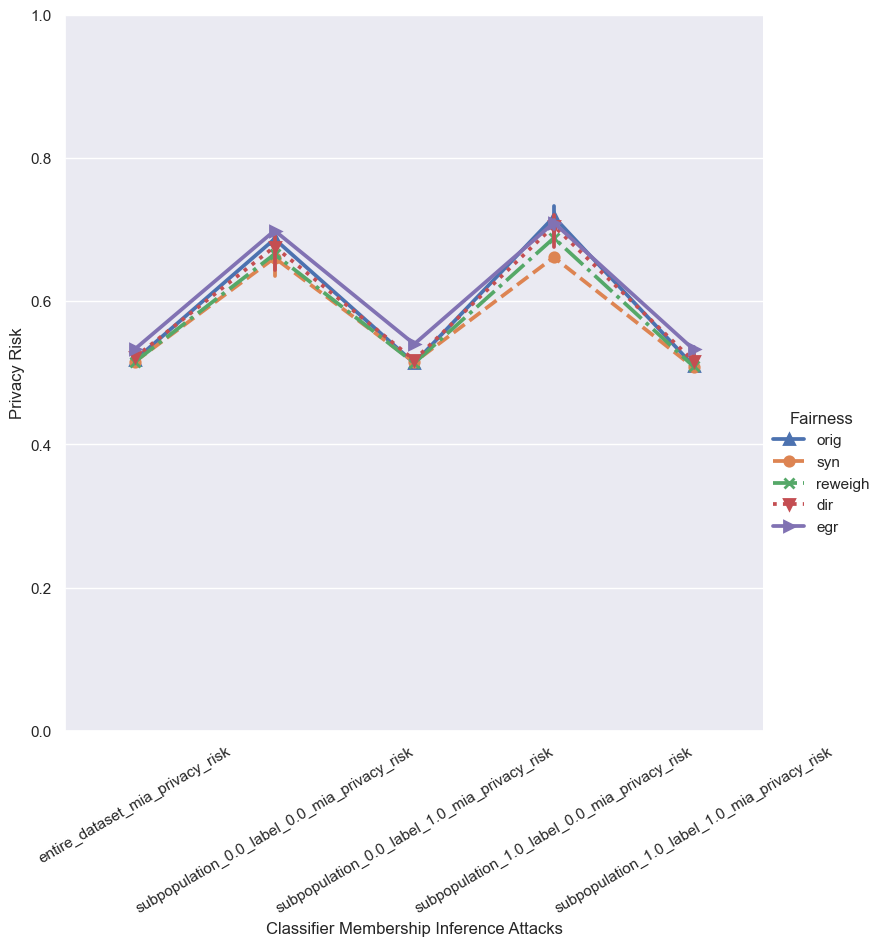

In [36]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [37]:
from sklearn.metrics import RocCurveDisplay, auc

In [38]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

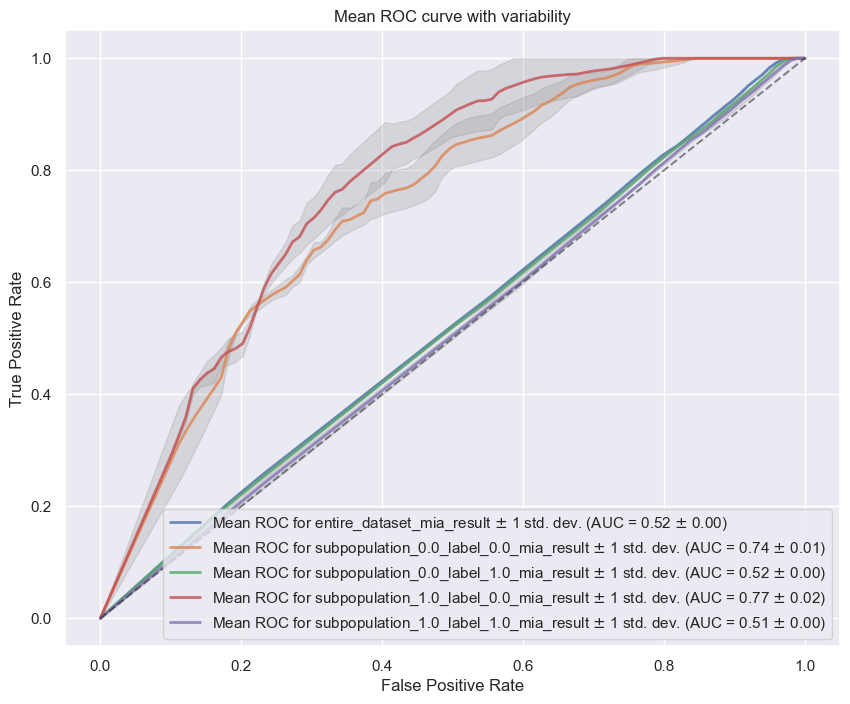

In [39]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

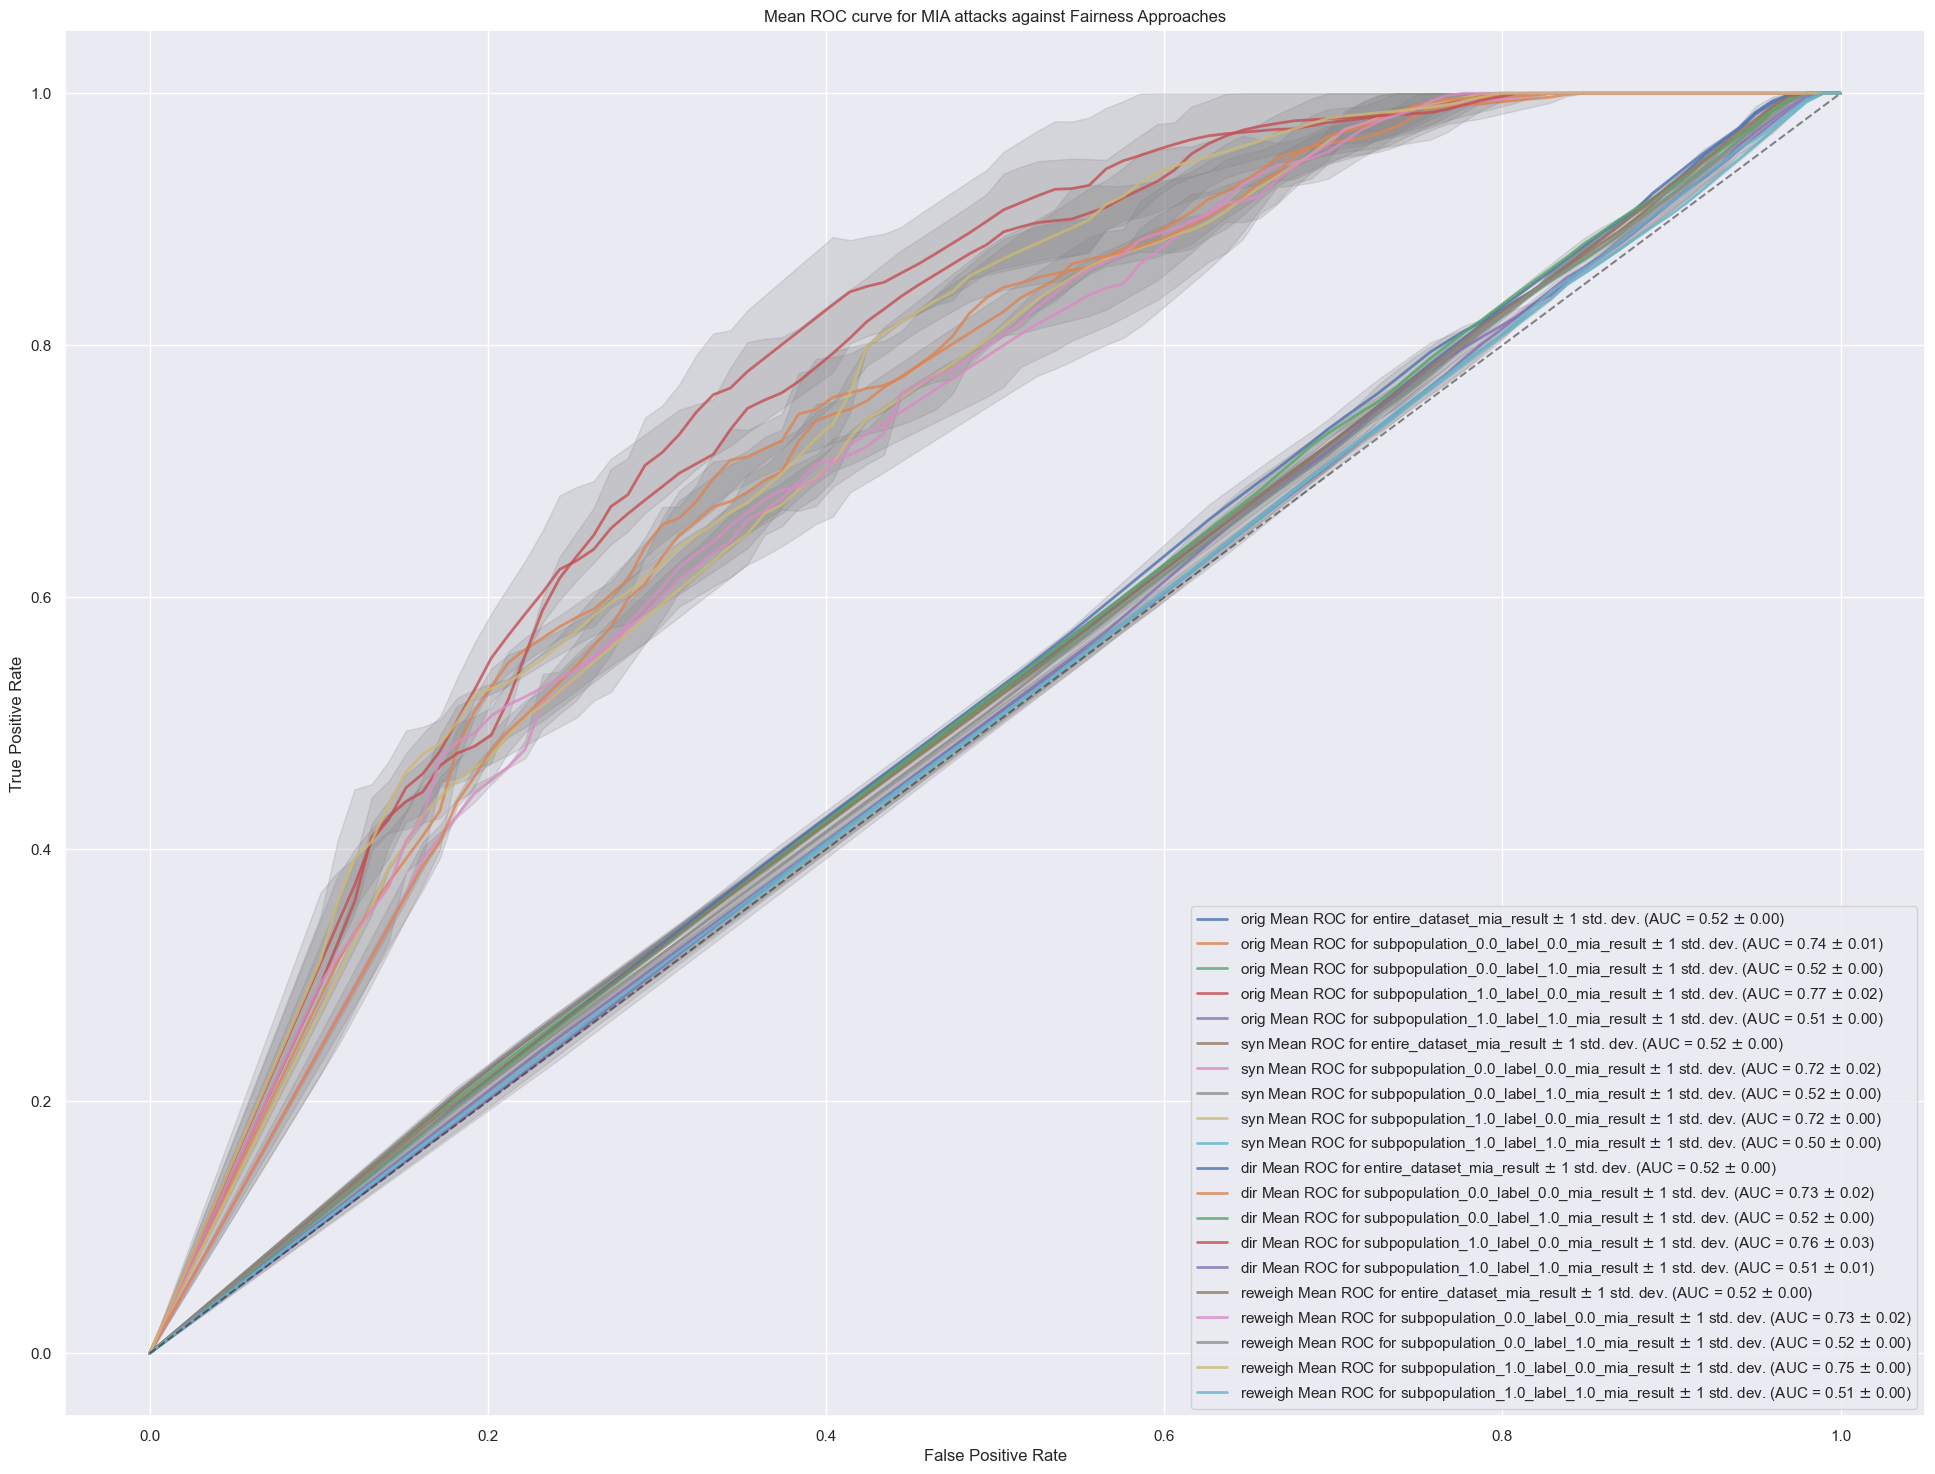

In [40]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

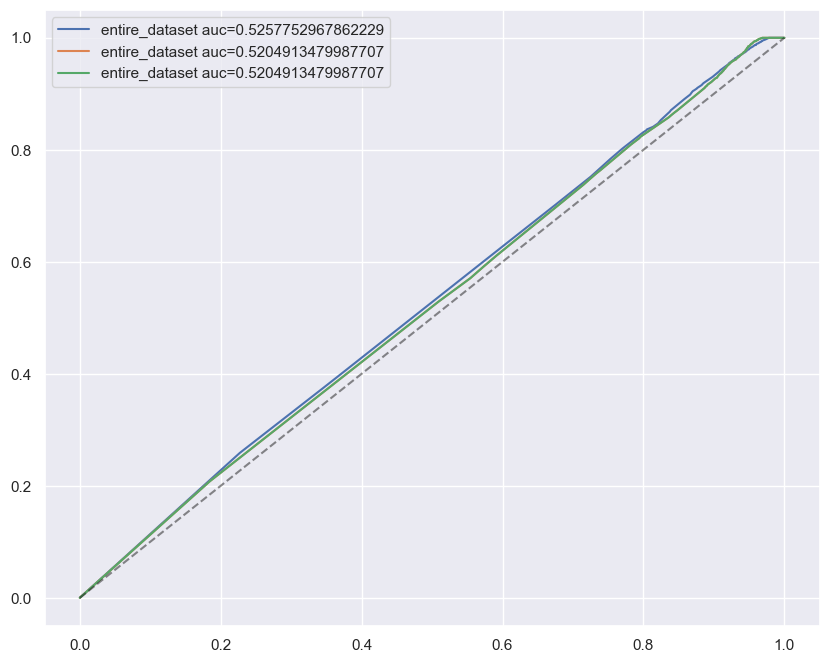

In [41]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [42]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [43]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5222526642612547,
 'entire_dataset_label_0.0_mia_auc': 0.7539600900599049,
 'entire_dataset_label_1.0_mia_auc': 0.512604221707123,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7389305116313727,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5183984958720554,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7705772872271065,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5076372479648169}

In [44]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.522253,0.753960,0.512604,0.738931,0.518398,0.770577,0.507637
syn,0.521372,0.719155,0.512297,0.715403,0.521705,0.723068,0.504946
dir,0.524197,0.745611,0.514735,0.725927,0.521526,0.765052,0.508942
rew,0.519784,0.739366,0.510385,0.726911,0.515362,0.750649,0.506313


<Axes: xlabel='Classifier MIA Attacks'>

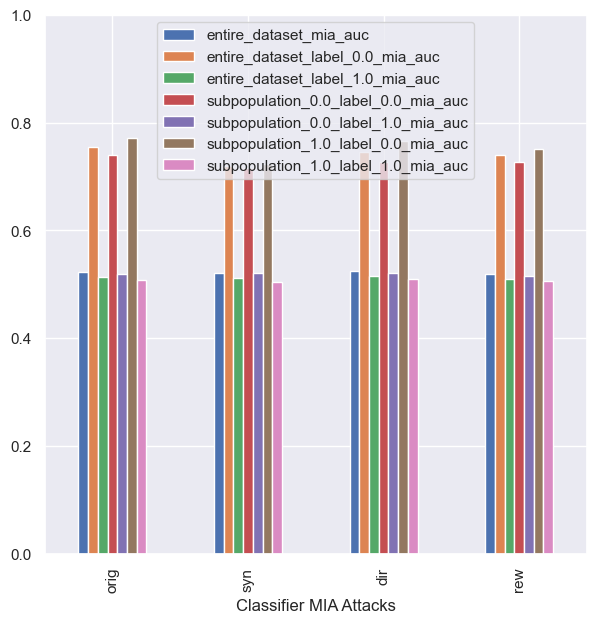

In [45]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [46]:
# Creating data structures to plot point categorical plot from seaborn

In [47]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [48]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03461871333782096,
  0.036253485912106864,
  0.036253485912106864],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.3417926805788,
  0.41997780244173144,
  0.41997780244173144],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.0255281975076479,
  0.020800487191184214,
  0.020800487191184214],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.3382446277994378,
  0.3919143409447868,
  0.3919143409447868],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.027047288943597647,
  0.027258877317612007,
  0.027258877317612007],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.3742303671003717,
  0.4661422807883203,
  0.4661422807883203],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.02683748883281012,
  0.01600364451663283,
  0.01600364451663283]}

In [49]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03461871333782096],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset_label_0.0', 0.3417926805788],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_1.0', 0.0255281975076479],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3382446277994378],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027047288943597647],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_1.0_label_0.0', 0.3742303671003717],
 ['orig', 'subpopulation_1.0_label_0.0', 0.46614228

In [50]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.034619
1,orig,entire_dataset,0.036253
2,orig,entire_dataset,0.036253
3,orig,entire_dataset_label_0.0,0.341793
4,orig,entire_dataset_label_0.0,0.419978
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.428294
101,egr,subpopulation_1.0_label_0.0,0.428294
102,egr,subpopulation_1.0_label_1.0,0.054580
103,egr,subpopulation_1.0_label_1.0,0.070896


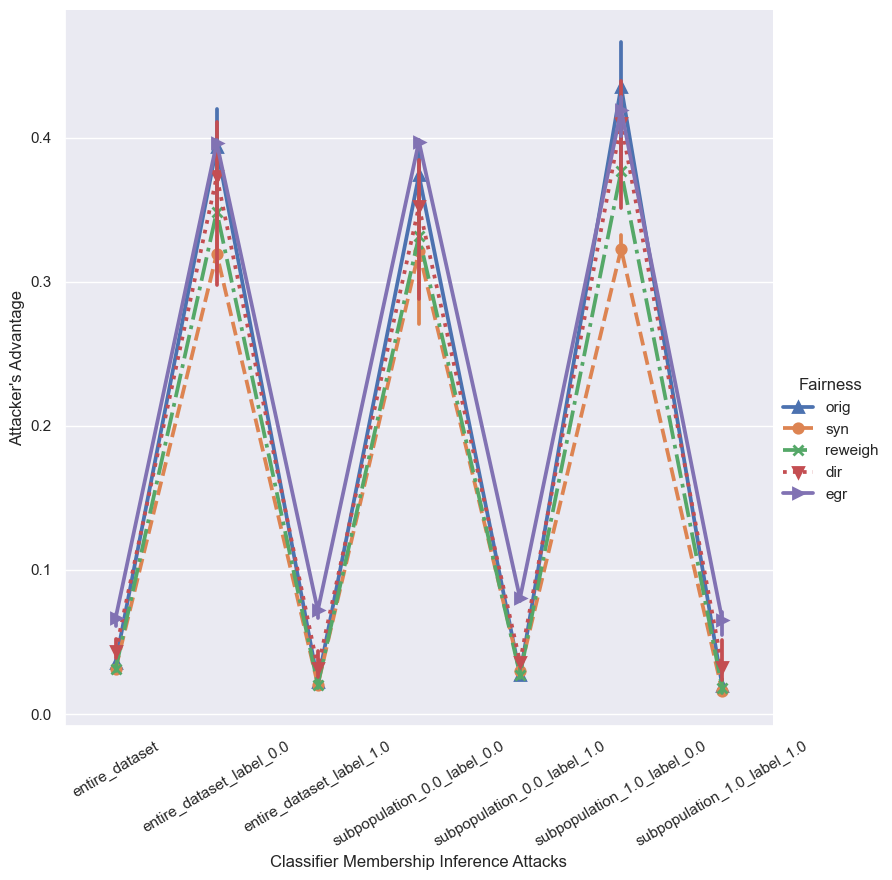

In [51]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


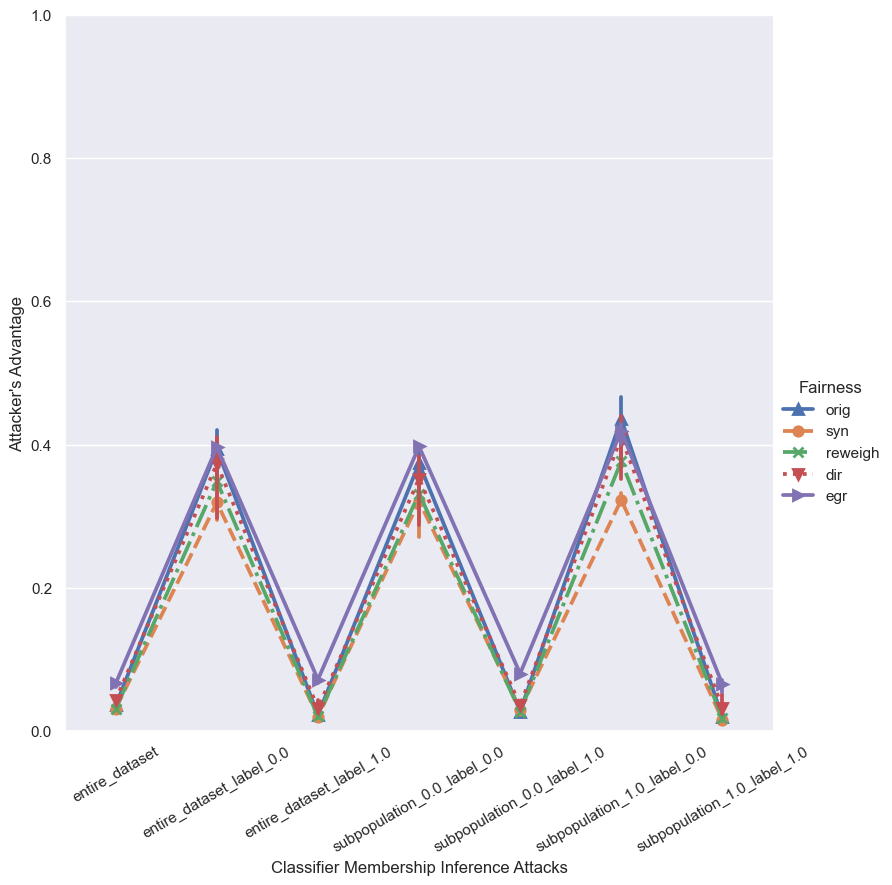

In [52]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [53]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.034619,0.341793,0.025528,0.338245,0.027047,0.374230,0.026837
1,0.036253,0.419978,0.020800,0.391914,0.027259,0.466142,0.016004
2,0.036253,0.419978,0.020800,0.391914,0.027259,0.466142,0.016004


In [54]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [55]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03570856172067823,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.39391609515408765,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.022376390630005443,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.3740244365630038,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.02718834785960722,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.4355049762256708,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.019614925955358593}

In [56]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.035709,0.393916,0.022376,0.374024,0.027188,0.435505,0.019615
syn,0.031349,0.319401,0.020287,0.321153,0.029703,0.322807,0.015902
dir,0.043466,0.373201,0.031828,0.352388,0.035948,0.410345,0.032792
rew,0.031317,0.348721,0.020468,0.331653,0.027265,0.376721,0.017891
egr,0.066609,0.396488,0.071891,0.397379,0.080334,0.419281,0.065458


<Axes: xlabel='Classifier MIA Attacks'>

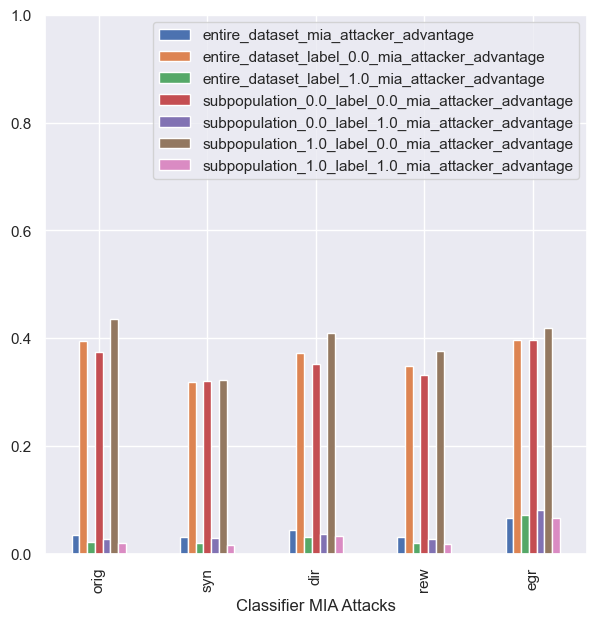

In [57]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [58]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [59]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.532554917870572],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset_label_0.0', 0.7786561264822135],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_1.0', 0.5195833333333333],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'subpopulation_0.0_label_0.0', 0.8],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5254824344383968],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7739726027397261],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7553956834532375],
 ['orig', 'subpopul

In [60]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.532555
1,orig,entire_dataset,0.530017
2,orig,entire_dataset,0.530017
3,orig,entire_dataset_label_0.0,0.778656
4,orig,entire_dataset_label_0.0,0.741722
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,1.000000
101,egr,subpopulation_1.0_label_0.0,1.000000
102,egr,subpopulation_1.0_label_1.0,0.509539
103,egr,subpopulation_1.0_label_1.0,0.524529


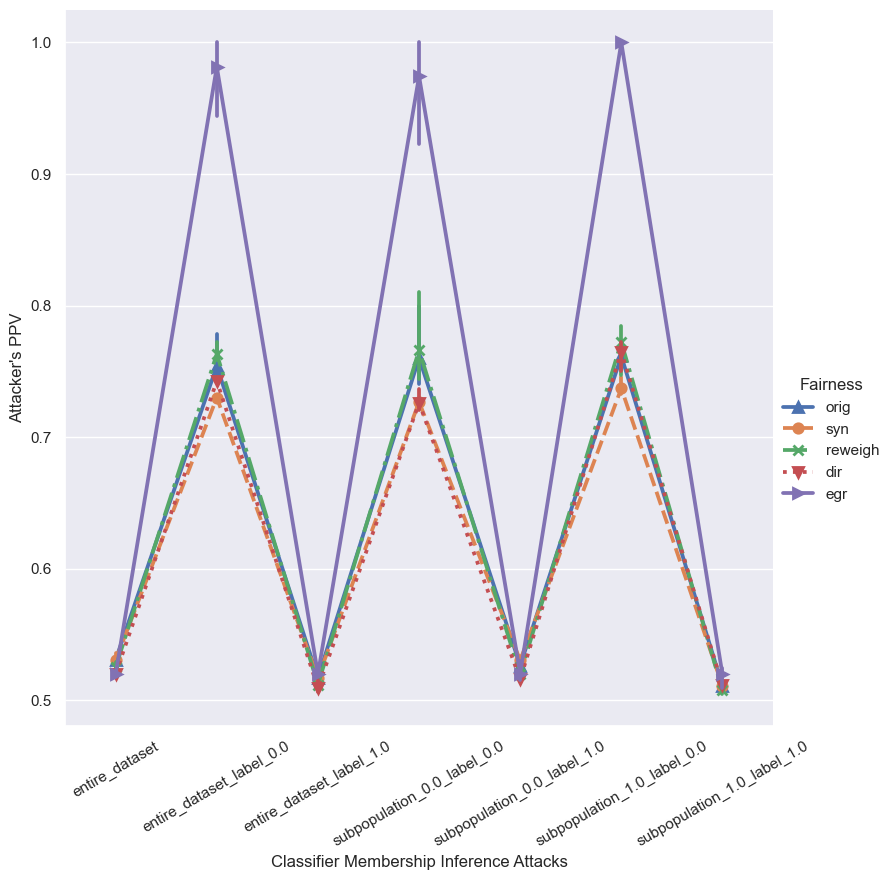

In [61]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [62]:
import pandas as pd

In [63]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,age,gender,race2,other,asian,black,hisp,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,7.0,1.0,44.0,3.5,69.0,1.0,5.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,7.0,2.0,29.0,3.5,69.0,1.0,4.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,7.0,1.0,37.0,3.4,68.0,1.0,3.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0
3,7.0,8.0,7.0,1.0,43.0,3.3,67.0,1.0,4.0,-60.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,7.0,4.0,41.0,3.3,64.0,1.0,4.0,-57.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,7.0,5.0,42.0,3.0,67.0,1.0,4.0,-60.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,7.0,3.0,29.5,3.5,68.0,1.0,4.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,3.0,3.0,33.0,3.1,69.0,1.0,3.0,-62.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,7.0,3.0,32.0,3.0,67.0,0.0,3.0,-65.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0


In [64]:
df[["age", "labels"]].value_counts(normalize=True)

age    labels
-62.0  1.0       0.245841
-61.0  1.0       0.171603
-60.0  1.0       0.100635
-59.0  1.0       0.069478
-58.0  1.0       0.048418
                   ...   
-24.0  1.0       0.000048
-26.0  1.0       0.000048
-28.0  0.0       0.000048
-33.0  0.0       0.000048
-3.0   1.0       0.000048
Name: proportion, Length: 95, dtype: float64

In [65]:
df.drop_duplicates()

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,age,gender,race2,other,asian,black,hisp,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,7.0,1.0,44.0,3.5,69.0,1.0,5.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,7.0,2.0,29.0,3.5,69.0,1.0,4.0,-62.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,7.0,1.0,37.0,3.4,68.0,1.0,3.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0
3,7.0,8.0,7.0,1.0,43.0,3.3,67.0,1.0,4.0,-60.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,7.0,4.0,41.0,3.3,64.0,1.0,4.0,-57.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,7.0,5.0,42.0,3.0,67.0,1.0,4.0,-60.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,7.0,3.0,29.5,3.5,68.0,1.0,4.0,-61.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,3.0,3.0,33.0,3.1,69.0,1.0,3.0,-62.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,7.0,3.0,32.0,3.0,67.0,0.0,3.0,-65.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
